## Test the Performance of Sparse Linear Regression

Test the performance of regular/sparse linear regression.

In [1]:
import numpy as np
import os, sys, copy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
metadata = pd.read_csv('../data/metafile_1026.csv', index_col=0, header=None, names=['feature', 'description'])
data = pd.read_csv('../data/global_dams_db_1026.csv')

In [3]:
# Delare a vector of features to use
# features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
#             'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'clz_cl_smj', 'ari_ix_sav', 
#             'ari_ix_uav', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 'for_pc_use', 'crp_pc_use', 'pst_pc_use', 
#             'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 'fmh_cl_smj', 'soc_th_uav', 'swc_pc_uyr', 
#             'lit_cl_smj', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 'hdi_ix_sav']

features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
            'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'ari_ix_sav', 'ari_ix_uav', 
            'for_pc_use', 'crp_pc_use', 'pst_pc_use', 'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 
            'soc_th_uav', 'swc_pc_uyr', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 
            'hdi_ix_sav', 'YEAR', 'CAP_MCM', 'RES_YLD_TN', 'RES_LSS_TN', 'CO2_total_per_GWH',
            'fish_per_GWH', 'capacity_factor']

In [4]:
# # Change categorial features to one-hot encoding
# categorial_features = ['clz_cl_smj', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 
#                        'fmh_cl_smj', 'lit_cl_smj', 'MAIN_USE', 'LAKE_CTRL']

# for feature in categorial_features:
#     categories = pd.unique(data[feature])
#     for category in categories:
#         key = '{}-{}'.format(feature, category)
#         data[key] = data[feature].apply(lambda x: 1 if x == category else 0)
#         features.append(key)

In [5]:
# # Add columns for CO2 per GWH and fish per GWH
# data['CO2_areal_per_GWH'] = data.apply(lambda x: x['CO2EQ_areal']/x['GEN_GWH_YR'], axis=1)
# data['CO2_total_per_GWH'] = data.apply(lambda x: x['CO2EQ_total']/x['GEN_GWH_YR'], axis=1)
# data['fish_per_GWH'] = data.apply(lambda x: (x['RES_BAL']/x['GEN_GWH_YR']), axis=1)

In [6]:
# Save the data with the new features
# data.to_csv('../data/global_dams_db__with_objs_0922.csv')

### CO2 per GWH

In [7]:
# Filter for dams with CO2 and power information
data_filt = data[data['CO2_total_per_GWH'].apply(lambda x: not pd.isna(x))]
data_filt = data_filt[features + ['GEN_GWH_YR']]
data_filt.shape

(477, 38)

In [8]:
# Generate the test and training data 
X = data_filt.drop(columns=['CO2_total_per_GWH'], inplace=False)
y = np.log(data_filt['CO2_total_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [9]:
# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [10]:
# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]
nas

DAM_LEN_M       36
YEAR             1
RES_YLD_TN      24
RES_LSS_TN      24
fish_per_GWH    24
dtype: int64

In [11]:
# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# Define alphas
alphas = [50, 25, 10, 5, 1, 0.5, 0]

In [13]:
# Train models and record R2 values and the number of parameters
test_r2s = np.zeros(len(alphas))
train_r2s = np.zeros(len(alphas))
n_params = np.zeros(len(alphas))
coeffs = {}
y_pred_test = {}
y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    if alpha == 0:
        reg = linear_model.LinearRegression()
    else:
        reg = linear_model.Lasso(alpha=alpha)
    reg.fit(X_train, y_train)    
    test_r2s[i] = reg.score(X_test, y_test)
    train_r2s[i] = reg.score(X_train, y_train)
    y_pred_test[alpha] = reg.predict(X_test)
    y_pred_train[alpha] = reg.predict(X_train)
    coeffs[alpha] = reg.coef_
    n_params[i] = len(coeffs[alpha][coeffs[alpha] != 0])

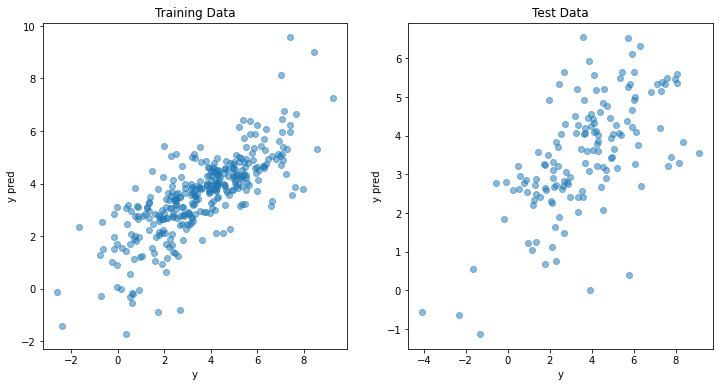

In [14]:
# Plot the y-values verus the predicted y-values for the regular regression
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


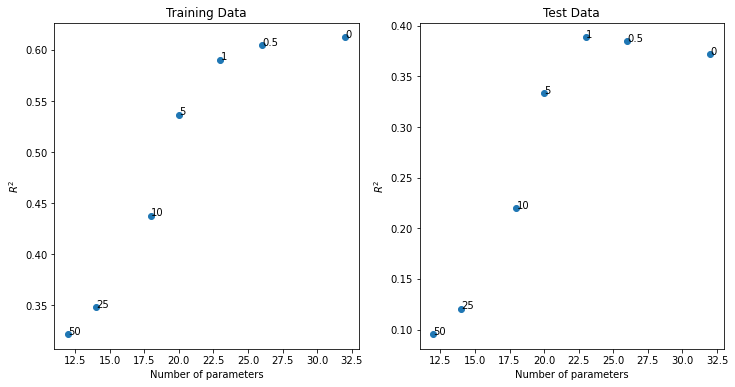

In [15]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(n_params, train_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.scatter(n_params, test_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.show()


In [16]:
train_r2s

array([0.32201919, 0.34827813, 0.43756352, 0.53650294, 0.59037634,
       0.60459448, 0.61219634])

In [17]:
# Create summary dataframes
summary = {}
for alpha in alphas:
    summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[coeffs[alpha] > 0], coeffs[alpha][coeffs[alpha] > 0]]).T)
    summary[alpha] = summary[alpha].join(metadata, on='feature')
    summary[alpha].sort_values(by='coeff', inplace=True, ascending=False)

In [18]:
summary[0]

,feature,coeff,description
7,gla_pc_use,0.065374,"Glacier extent, in percent, in total watershed..."
11,urb_pc_use,0.0401286,"Urban spatial extent, in percent, in total wat..."
5,ari_ix_uav,0.00971423,"Global aridity index, in total watershed upstr..."
8,pac_pc_use,0.00527019,"Protected area extent, in percent, in total wa..."
4,inu_pc_umn,0.00516737,Annual minimum inundation extent in total wate...
1,DOR_PC,0.00215081,Degree of regulation in percent; equivalent to...
6,for_pc_use,0.000995473,"Forest cover extent, in percent, in total wate..."
0,AREA_SKM,0.000281177,Surface area of reservoir
10,pop_ct_usu,3.43738e-05,"Population count, thousands of people"
9,ero_kh_uav,1.13772e-05,"Soil erosion, in kg per hectare per year, in t..."


In [19]:
summary[0.5]

,feature,coeff,description
10,urb_pc_use,0.0214564,"Urban spatial extent, in percent, in total wat..."
5,ari_ix_uav,0.00421911,"Global aridity index, in total watershed upstr..."
7,pac_pc_use,0.00375943,"Protected area extent, in percent, in total wa..."
4,inu_pc_umn,0.00297439,Annual minimum inundation extent in total wate...
1,DOR_PC,0.00208082,Degree of regulation in percent; equivalent to...
6,for_pc_use,0.000409079,"Forest cover extent, in percent, in total wate..."
0,AREA_SKM,0.000276992,Surface area of reservoir
9,pop_ct_usu,3.22313e-05,"Population count, thousands of people"
11,CAP_MCM,1.15648e-05,"Maximum storage capacity of the reservoir, in ..."
2,GDP_capita,1.09146e-05,"GDP per capita of country, in 2020 US $"


### Change in Fish per GWH

In [20]:
# Filter for dams with fish and power information
data_filt = data[data['fish_per_GWH'].apply(lambda x: not pd.isna(x))]
data_filt = data_filt[features]

In [21]:
# Generate the test and training data 
X = data_filt.drop(columns=['fish_per_GWH'], inplace=False)
y = np.log(np.abs(data_filt['fish_per_GWH'])) * np.sign(data_filt['fish_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]

In [23]:
# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [25]:
# Define alphas
alphas = [1, 0.5, 0.1, 0.05, 0]

In [26]:
# Train models and record R2 values and the number of parameters
test_r2s = np.zeros(len(alphas))
train_r2s = np.zeros(len(alphas))
n_params = np.zeros(len(alphas))
coeffs = {}
y_pred_test = {}
y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    if alpha == 0:
        reg = linear_model.LinearRegression()
    else:
        reg = linear_model.Lasso(alpha=alpha)
    reg.fit(X_train, y_train)    
    test_r2s[i] = reg.score(X_test, y_test)
    train_r2s[i] = reg.score(X_train, y_train)
    y_pred_test[alpha] = reg.predict(X_test)
    y_pred_train[alpha] = reg.predict(X_train)
    coeffs[alpha] = reg.coef_
    n_params[i] = len(coeffs[alpha][coeffs[alpha] != 0])

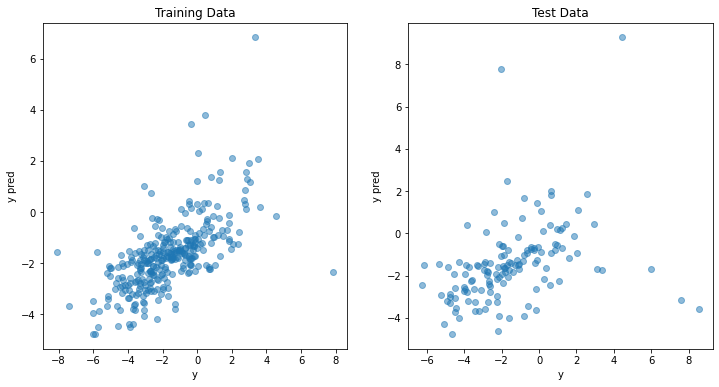

In [27]:
# Plot the y-values verus the predicted y-values for the regular regression
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


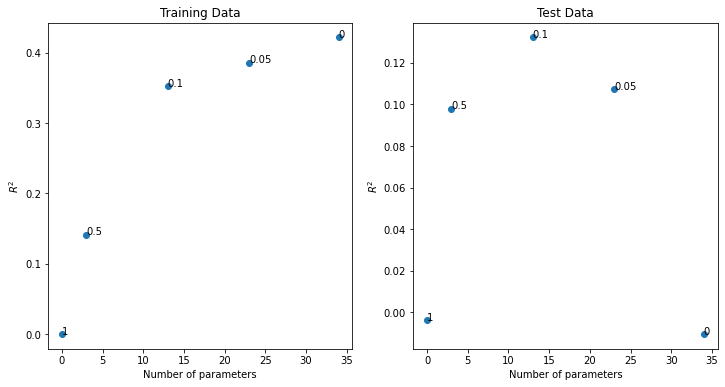

In [28]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(n_params, train_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.scatter(n_params, test_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.show()


In [29]:
train_r2s

array([0.        , 0.14086563, 0.35257602, 0.38582191, 0.42161139])

In [30]:
# Create summary dataframes
summary = {}
for alpha in alphas:
    summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[coeffs[alpha] > 0], coeffs[alpha][coeffs[alpha] > 0]]).T)
    summary[alpha] = summary[alpha].join(metadata, on='feature')
    summary[alpha].sort_values(by='coeff', inplace=True, ascending=False)

In [31]:
summary[0]

,feature,coeff,description
4,Population,0.673008,Populatin of country
16,CO2_total_per_GWH,0.665153,NaN
2,DIS_AVG_LS,0.372373,"Long-term average discharge, in liters per second"
15,RES_LSS_TN,0.313278,Fish catch from the pre-dam riverine area in t...
0,DAM_HGT_M,0.305545,"Height of dam structure, in meters"
12,ppd_pk_uav,0.256974,"Population density, people per km2"
11,pop_ct_usu,0.222526,"Population count, thousands of people"
6,sgr_dk_sav,0.185229,"Stream gradient, in decimeters per km, along t..."
1,AREA_SKM,0.18151,Surface area of reservoir
7,ari_ix_sav,0.144433,"Global aridity index, in the reach catchment"
